### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2404,2534,0,0,130,2469.0,0,-130,0,20.0,...,0.0,1.0,0.0,0.0,0.0,34.0,33.0,0,11.0,1.0
1,2752,2395,2,0,357,2573.5,1,357,0,16.0,...,0.0,0.0,0.0,1.0,1.0,27.0,27.0,0,18.0,0.0
2,2558,2685,2,0,127,2621.5,0,-127,1,22.0,...,1.0,0.0,0.0,0.0,0.0,30.0,32.0,0,14.0,-2.0
3,2514,2351,0,0,163,2432.5,1,163,0,6.0,...,0.0,0.0,0.0,2.0,2.0,21.0,23.0,0,20.0,-2.0
4,2582,2494,2,0,88,2538.0,1,88,0,18.0,...,0.0,0.0,2.0,2.0,4.0,35.0,41.0,0,17.0,-6.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1686173, 33)
Target: (1686173,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 19.44 seconds (0.32 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.6341 (63.41%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.62      0.71      0.66    132965
        Draw       0.75      0.31      0.44     64732
   White Win       0.63      0.71      0.67    139538

    accuracy                           0.63    337235
   macro avg       0.66      0.58      0.59    337235
weighted avg       0.65      0.63      0.62    337235



### 6. Confusion Matrix

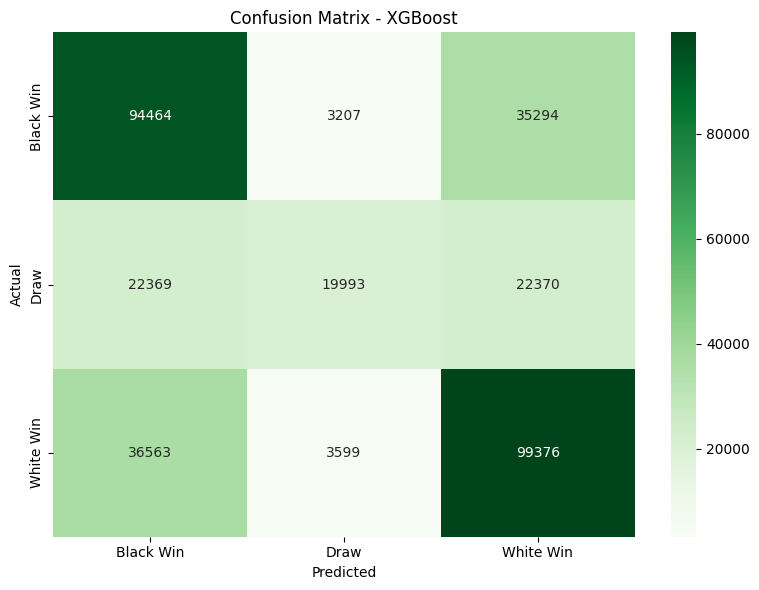

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
10    material_diff_early    0.238440
4               AvgRating    0.229044
6    WhiteRatingAdvantage    0.081422
0                WhiteElo    0.059983
1                BlackElo    0.049467
3              RatingDiff    0.035352
31   total_captures_early    0.025815
2             EventTypeID    0.025479
32          activity_diff    0.023967
9        b_material_early    0.023437
12       b_captures_early    0.021553
21          b_development    0.021536
8        w_material_early    0.017913
15     b_aggression_early    0.016681
20          w_development    0.014679
29       b_piece_activity    0.014318
13     capture_diff_early    0.013486
16  aggression_diff_early    0.012985
11       w_captures_early    0.009979
28       w_piece_activity    0.009312
22       development_diff    0.006837
26         b_checks_early    0.006645
5      WhiteIsHigherRated    0.006511
19            center_diff    0.006329
27           early_checks    0.005350
7           

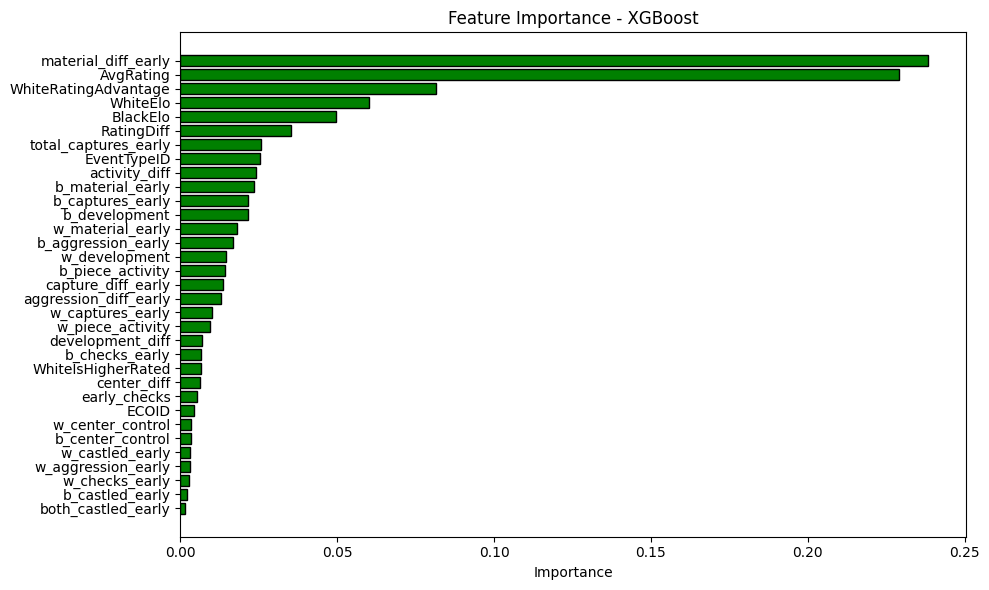

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()